In [46]:
import torch
import numpy as np 
import torch.nn as nn
import torchvision.transforms as transforms 
import torchvision.datasets as datasets 


In [47]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train = False,transform = transforms.ToTensor(), download = True )

In [48]:
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)

In [49]:
print(f"# Images Train: {n_imgs_train}")
print(f"# Images Test:  {n_imgs_test}")

# Images Train: 60000
# Images Test:  10000


In [50]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


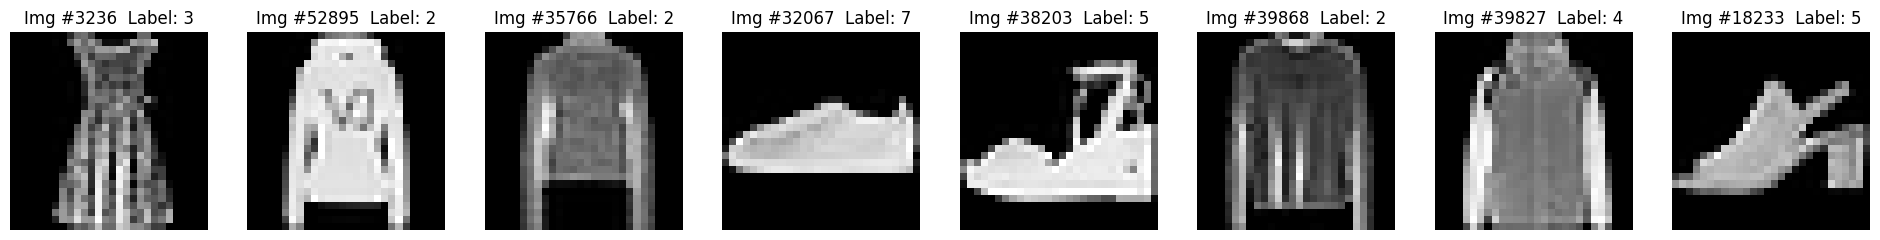

In [51]:
import matplotlib.pyplot as plt

N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(28,28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

In [52]:
BATCH_SIZE = 1024
SHUFFLE_TRAIN = True
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [53]:
imgs, labels = next(iter(eval_loader))
print(f"{imgs.shape = }")
print(f"{labels.shape = }")

imgs.shape = torch.Size([1024, 1, 28, 28])
labels.shape = torch.Size([1024])


In [69]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [70]:
model = Model(input_dim=784, hidden_dim=128, output_dim=10)
print(model)

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [71]:
imgs, labels = next(iter(eval_loader))      # sampling images
flattened_imgs = imgs.flatten(start_dim=1)  # reshaping to desired size
output = model(flattened_imgs)              # forward pass through model

print(f"Imgs shape:         {imgs.shape}")
print(f"Model input shape:  {flattened_imgs.shape}")
print(f"Model output shape: {output.shape}")

Imgs shape:         torch.Size([1024, 1, 28, 28])
Model input shape:  torch.Size([1024, 784])
Model output shape: torch.Size([1024, 10])


In [72]:
NUM_EPOCHS = 10
LR = 3e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=784, hidden_dim=128, output_dim=10)
model = model.to(device)

In [73]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [74]:
from tqdm import tqdm

loss_list = []

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    
        # computing error
        loss = criterion(preds, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating arameters
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 10 Iter 59: loss 0.37423. : 100%|██████████| 59/59 [00:14<00:00,  4.04it/s]


In [60]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

In [61]:


plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_loss = smooth(loss_list, 31)
ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [75]:
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
        
        pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

Test accuracy: 84.14%
